# Counting with dead time
How much does it matter and can we understand it with MCMC

Using wikipedia and others names below: https://en.wikipedia.org/wiki/Dead_time

Bottom work is based on Adams RP, Murray I, MacKay DJC. Tractable nonparametric Bayesian inference in Poisson processes with Gaussian process intensities.  Proceedings of the 26th Annual International Conference on Machine Learning; Montreal, Quebec, Canada. 1553376: ACM; 2009. p. 9-16.



In [1]:
%matplotlib inline

from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as mc
import spacepy.toolbox as tb
import spacepy.plot as spp
import tqdm
from scipy import stats
import seaborn as sns
sns.set()
matplotlib.pyplot.rc('figure', figsize=(10,10))
matplotlib.pyplot.rc('lines', lw=3)
matplotlib.pyplot.rc('font', size=20)



%matplotlib inline

/Users/balarsen/miniconda3/envs/python3/lib/python3.6/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


## Generate some data

In [2]:
np.random.seed(8675309)
Rate1 = 10
Rate2 = 20
deadtime = 0.05

times1 = np.random.exponential(1/Rate1, size=1000)
times2 = np.random.exponential(1/Rate2, size=1000)

times = pd.DataFrame({'between1':times1, 'between2':times2})
times['times1'] = np.cumsum(times['between1'])
times['times2'] = np.cumsum(times['between2'])

# get the times of bunch of hits

AxesSubplot(0.125,0.125;0.352273x0.755)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x110e82a58>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11145cbe0>]], dtype=object)

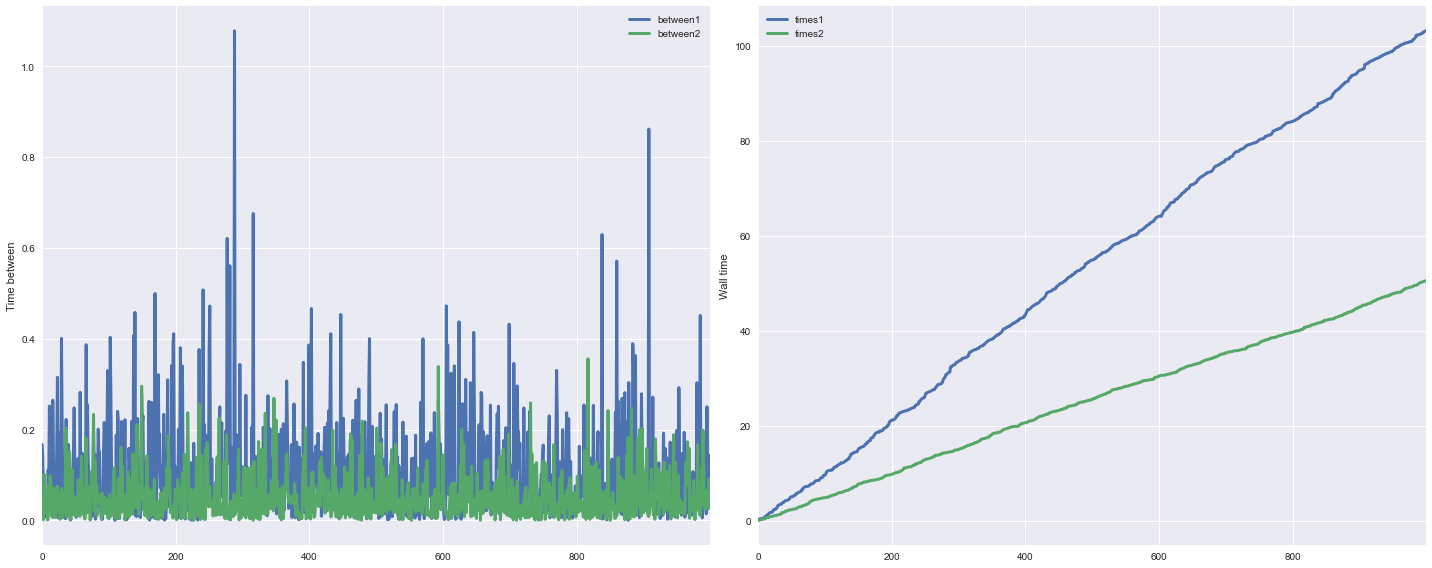

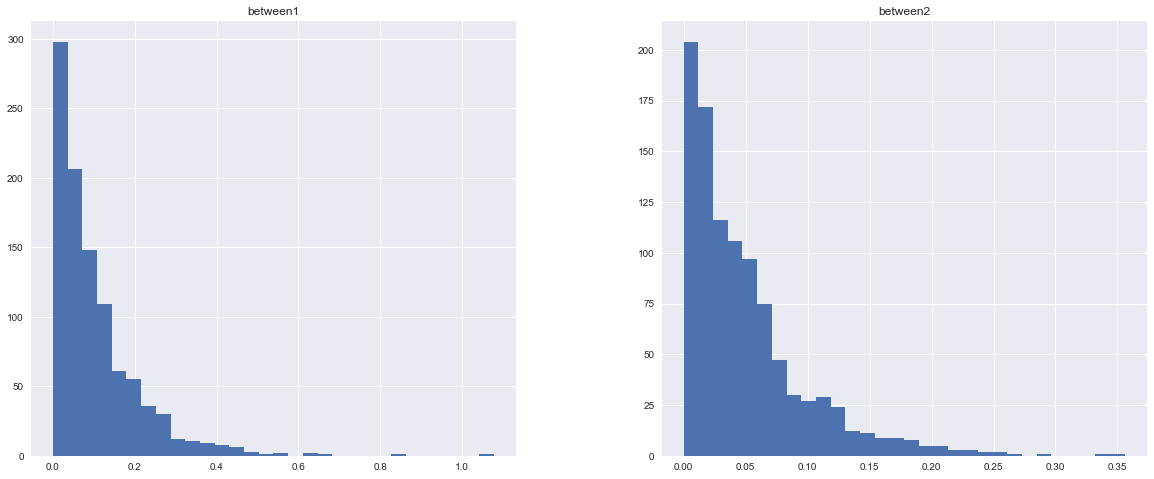

In [3]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,8), squeeze=False)
print(ax[0][0])
times[['between1', 'between2']].plot(ax=ax[0][0])
ax[0][0].set_ylabel('Time between')
times[['times1', 'times2']].plot(ax=ax[0][1])
ax[0][1].set_ylabel('Wall time')
plt.tight_layout()
plt.figure(figsize=(20,8))
times[['between1', 'between2']].hist(bins=30, figsize=(20,8))


In [4]:
# make cts per unit
realcps1 = np.histogram(times['times1'], bins=np.arange(0, times['times1'].max()))[0]
realcps2 = np.histogram(times['times2'], bins=np.arange(0, times['times2'].max()))[0]
    

In [5]:
# then cull out all points and are closer than deadtime to each other
times['between1dt'] = times['between1'].copy()
times['between1dt'].loc[times['between1dt'] < deadtime] = np.nan
times['between2dt'] = times['between2'].copy()
times['between2dt'].loc[times['between2dt'] < deadtime] = np.nan

times['times1dt'] = np.cumsum(times['between1dt'])
times['times2dt'] = np.cumsum(times['between2dt'])

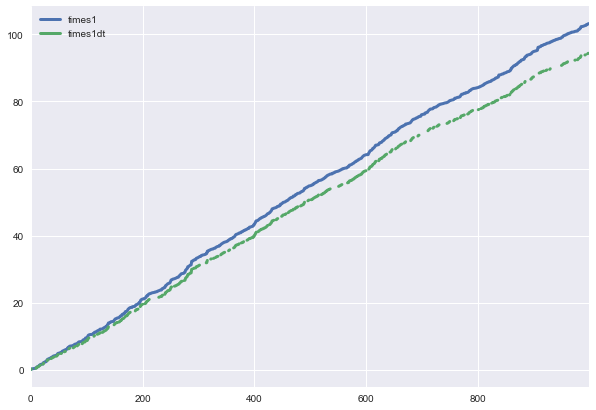

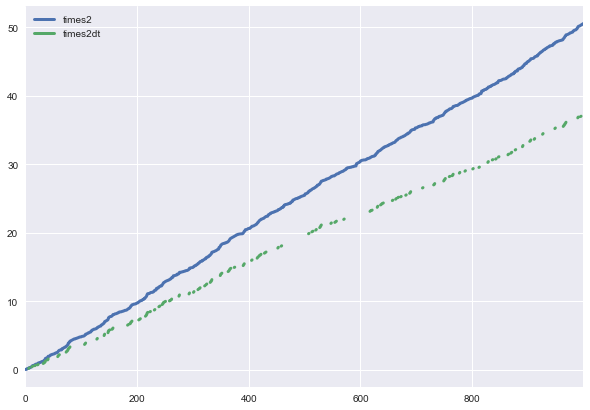

In [6]:
times[['times1', 'times1dt']].plot(figsize=(10,7))
times[['times2', 'times2dt']].plot(figsize=(10,7))

In [7]:
dtcps1 = np.histogram(times['times1dt'].dropna(), bins=np.arange(0, times['times1dt'].dropna().max()))[0]
dtcps2 = np.histogram(times['times2dt'].dropna(), bins=np.arange(0, times['times2dt'].dropna().max()))[0]


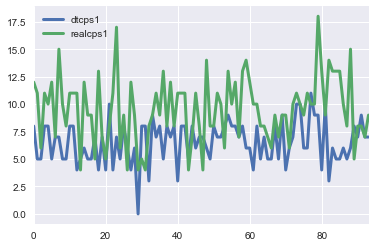

In [8]:
df = pd.DataFrame({'dtcps1':dtcps1, 'realcps1':realcps1[:len(dtcps1)]})
df.plot()

# TODO looks wrong!!

In [9]:
np.random.seed(8675309)
size = 100
n_rate = 6
data = np.empty((n_rate, size))
for ii, d in enumerate(tb.linspace(1, 100, n_rate)):
    data[ii] = np.random.poisson(d, size=size)
print(data.shape)


(6, 100)


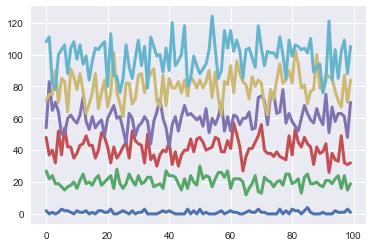

In [10]:
plt.plot(data.T);


From the reference: 

The relationship of the real counting rates with the
measured counting rates is well known for these two basic
models. If we denote by N the real counting rate, by M
the measured counting rate, and by τ the dead time and
considering that the non-dead time disturbed distribution is
Poissonian, M and N are related by

$N=\frac{M}{1-M\tau}$

for the case of a non-paralyzable dead time, and by

$M=Ne^{-N\tau}$

## No dead time just run

In [11]:
with mc.Model() as model0:
    mu = mc.Uniform('mu', 0, 1e6, shape=n_rate)
    dat = mc.Poisson('dat', mu=mu, observed=data.T, shape=n_rate)
    #     det2 = mc.Poisson('d2', mu=mu, observed=d2[0:10])
    start = mc.find_MAP()
    trace0 = mc.sample(10000, start=start)

         Current function value: 67475834.636572
         Iterations: 1
         Function evaluations: 18
         Gradient evaluations: 6


Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 1.435e+07:   6%|▋         | 12685/200000 [00:04<01:07, 2778.12it/s] 
Convergence archived at 12900
Interrupted at 12,900 [6%]: Average Loss = 1.0678e+08
100%|█████████▉| 10488/10500 [00:59<00:00, 174.92it/s]/Users/balarsen/miniconda3/envs/python3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.995974418256, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 10500/10500 [01:00<00:00, 174.92it/s]


In [12]:
mc.summary(trace0)


mu:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.031            0.100            0.003            [0.839, 1.226]
  20.476           0.451            0.006            [19.589, 21.360]
  40.878           0.639            0.007            [39.698, 42.179]
  60.255           0.778            0.007            [58.743, 61.753]
  79.932           0.894            0.008            [78.225, 81.718]
  98.518           0.963            0.008            [96.666, 100.428]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.844          0.962          1.029          1.097          1.234
  19.599         20.167         20.470         20.778         21.378
  39.651         40.439         40.870         41.309         42.147
  58.736         59.723         60.252         60.782         61.751

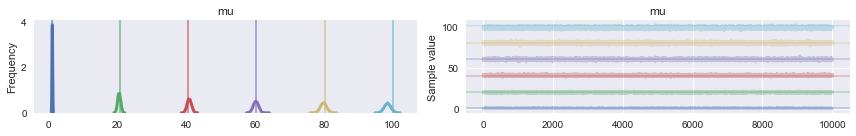

In [13]:
ax = mc.traceplot(trace0, lines={'mu':tb.linspace(1, 100, n_rate)})


# Tractable nonparametric Bayesian inference in Poisson processes with Gaussian process intensities